<a href="https://colab.research.google.com/github/Jimmynycu/Trump_Stock_Influence/blob/main/Trump.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install newsapi-python yfinance vaderSentiment torch transformers scikit-learn tensorflow statsmodels --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.4 MB/s eta 0:00:00


--- Step 1: Configuration for Minute-level Analysis ---
Attempting to fetch market data from 2025-06-09 to 2025-06-16

--- Step 3: Fetching MINUTE-LEVEL Market Data ---
Fetched 1912 minutes of market data.

Attempting to fetch news data from 2025-06-09 to 2025-06-13 for query: 'US Economy'

--- Step 2: Fetching News Data ---
Stopping pagination due to API message: {'status': 'error', 'code': 'maximumResultsReached', 'message': 'You have requested too many results. Developer accounts are limited to a max of 100 results. You are trying to request results 100 to 200. Please upgrade to a paid plan if you need more results.'}
Fetched 92 articles.

--- Step 4: Performing Sentiment Analysis ---

--- Step 5: Aggregating Sentiment per Minute ---
Aggregated news into 87 unique minutes.

--- Step 6: Merging DataFrames ---
Found 8 minutes with both market data and news articles.

--- Step 7: Analyzing the Relationship ---

Correlation on a MINUTE level: -0.5813


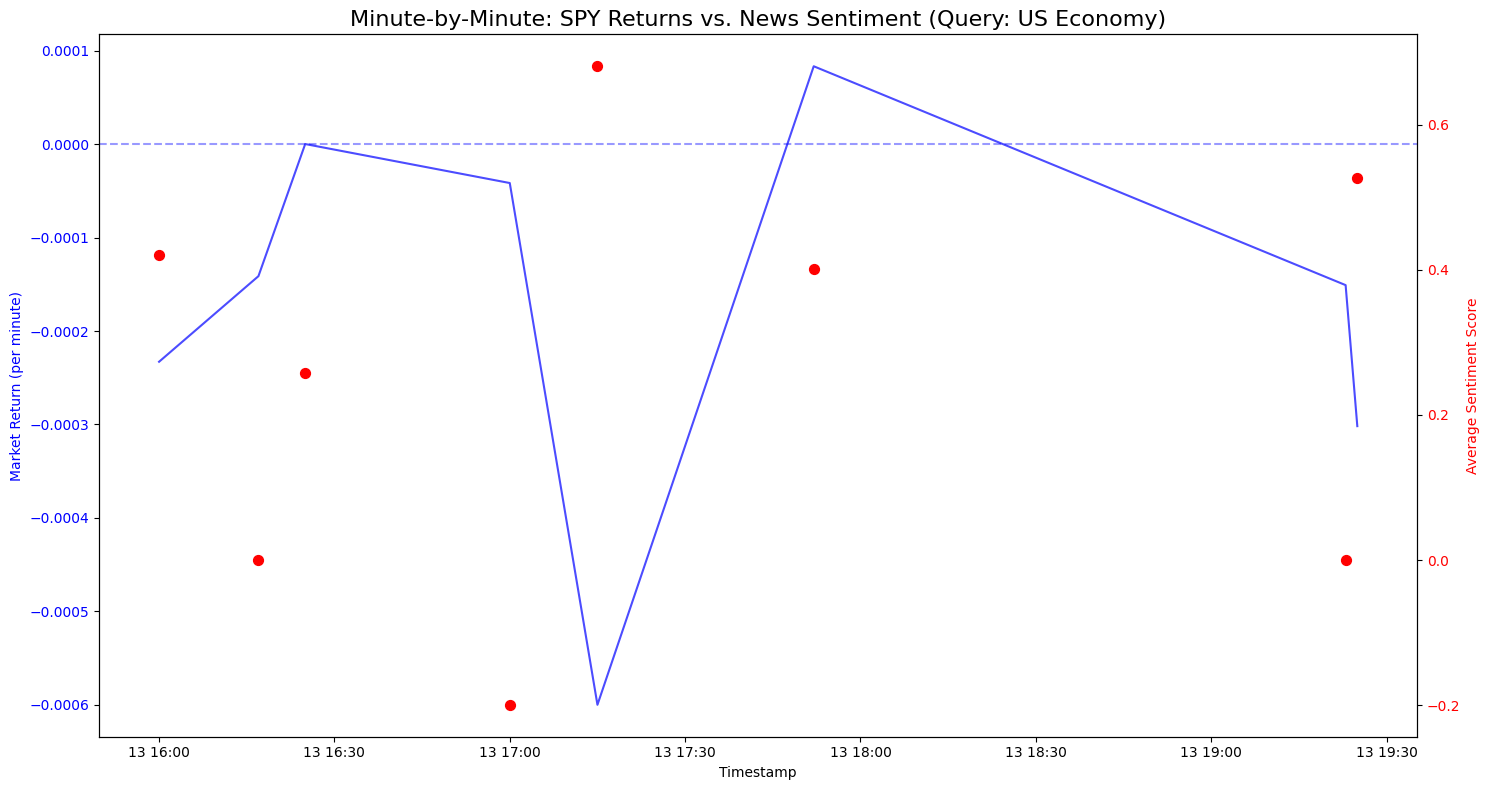

In [7]:
import pandas as pd
from datetime import datetime, timedelta
from newsapi import NewsApiClient
import yfinance as yf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1.1 Configuration for Minute-level Analysis ---
print("--- Step 1: Configuration for Minute-level Analysis ---")
API_KEY = 'cd574452c3134487b0ec551ee7a85ac0' # Replace with your API key
SEARCH_QUERY = 'US Economy' # User can change this
MARKET_TICKER = 'SPY'

# --- Determine the appropriate date range based on available data ---
# Start by fetching market data for the last few trading days
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=7) # Fetch market data for the last 7 days initially to capture trading days

START_DATE_STR = START_DATE.strftime('%Y-%m-%d')
END_DATE_STR = END_DATE.strftime('%Y-%m-%d')

print(f"Attempting to fetch market data from {START_DATE_STR} to {END_DATE_STR}")

# --- 1.3 Fetch Market Data ---
print("\n--- Step 3: Fetching MINUTE-LEVEL Market Data ---")
ticker_obj = yf.Ticker(MARKET_TICKER)
market_df = ticker_obj.history(start=START_DATE_STR, end=END_DATE_STR, interval='1m', auto_adjust=True)

if market_df.empty:
    print(f"ERROR: No minute-level data found for {MARKET_TICKER} in the range {START_DATE_STR} to {END_DATE_STR}.")
    print("This could be because there were no trading minutes in this range or the ticker does not have minute-level data available.")
    print("Please try a different date range that includes active trading days or verify the ticker.")
    exit()

market_df.reset_index(inplace=True)
market_df.rename(columns={'Datetime': 'timestamp'}, inplace=True)
# Make market timestamp naive UTC and round to the minute
market_df['timestamp'] = pd.to_datetime(market_df['timestamp']).dt.tz_convert('UTC').dt.tz_localize(None).round('min')
market_df['market_return'] = market_df['Close'].pct_change()
print(f"Fetched {len(market_df)} minutes of market data.")

# --- Now fetch news data for the same date range as the market data ---
news_start_date = market_df['timestamp'].min().strftime('%Y-%m-%d')
news_end_date = market_df['timestamp'].max().strftime('%Y-%m-%d')

print(f"\nAttempting to fetch news data from {news_start_date} to {news_end_date} for query: '{SEARCH_QUERY}'")

# --- 1.2 Fetch News Articles (with Pagination) ---
print("\n--- Step 2: Fetching News Data ---")
newsapi = NewsApiClient(api_key=API_KEY)
articles_data = []
MAX_PAGES = 5
PAGE_SIZE = 100

for page_num in range(1, MAX_PAGES + 1):
    try:
        all_articles = newsapi.get_everything(q=SEARCH_QUERY, from_param=news_start_date, to=news_end_date, language='en', sort_by='publishedAt', page_size=PAGE_SIZE, page=page_num)
        page_articles = all_articles['articles']
        if not page_articles: break
        for article in page_articles:
            articles_data.append({
                'timestamp': pd.to_datetime(article['publishedAt']),
                'title': article['title']
            })
    except Exception as e:
        print(f"Stopping pagination due to API message: {e}")
        break

if not articles_data:
    print(f"ERROR: No articles were returned from the News API for the query '{SEARCH_QUERY}' in the range {news_start_date} to {news_end_date}. Try a different search query or date range.")
    # Create an empty news_df to avoid errors in subsequent steps
    news_df = pd.DataFrame(columns=['timestamp', 'title'])
else:
    news_df = pd.DataFrame(articles_data)
    # Convert news timestamp to naive UTC to match market data format and round to minute
    news_df['timestamp'] = news_df['timestamp'].dt.tz_convert('UTC').dt.tz_localize(None).round('min')
    print(f"Fetched {len(news_df)} articles.")


# --- 2.1 Perform Sentiment Analysis ---
print("\n--- Step 4: Performing Sentiment Analysis ---")
if not news_df.empty:
    analyzer = SentimentIntensityAnalyzer()
    news_df['sentiment'] = news_df['title'].apply(lambda text: analyzer.polarity_scores(text)['compound'])
else:
    print("No news data to perform sentiment analysis on.")
    news_df['sentiment'] = np.nan


# --- 2.2 Aggregate Sentiment by MINUTE ---
print("\n--- Step 5: Aggregating Sentiment per Minute ---")
if not news_df.empty:
    sentiment_per_minute_df = news_df.groupby('timestamp')['sentiment'].mean().reset_index()
    sentiment_per_minute_df.rename(columns={'sentiment': 'avg_sentiment'}, inplace=True)
    print(f"Aggregated news into {len(sentiment_per_minute_df)} unique minutes.")
else:
    print("No news data to aggregate sentiment.")
    sentiment_per_minute_df = pd.DataFrame(columns=['timestamp', 'avg_sentiment'])


# --- 2.3 Merge DataFrames on the Minute ---
print("\n--- Step 6: Merging DataFrames ---")
# Perform an inner merge to keep only rows where both dataframes have a matching timestamp
merged_df = pd.merge(market_df, sentiment_per_minute_df, on='timestamp', how='inner')
merged_df.dropna(subset=['market_return', 'avg_sentiment'], inplace=True)
print(f"Found {len(merged_df)} minutes with both market data and news articles.")

# --- Step 7: Analyze and Visualize ---
if merged_df.empty:
    print("\nERROR: The merged DataFrame is empty. No news articles were published during market trading minutes in the selected range.")
    print("Consider adjusting the date range or the search query.")
else:
    print("\n--- Step 7: Analyzing the Relationship ---")
    correlation = merged_df['avg_sentiment'].corr(merged_df['market_return'])
    print(f"\nCorrelation on a MINUTE level: {correlation:.4f}")

    fig, ax1 = plt.subplots(figsize=(15, 8))
    ax1.set_title(f'Minute-by-Minute: {MARKET_TICKER} Returns vs. News Sentiment (Query: {SEARCH_QUERY})', fontsize=16)
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Market Return (per minute)', color='blue')
    ax1.plot(merged_df['timestamp'], merged_df['market_return'], color='blue', label='Market Return', alpha=0.7)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.axhline(0, color='blue', linestyle='--', alpha=0.4)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Average Sentiment Score', color='red')
    ax2.scatter(merged_df['timestamp'], merged_df['avg_sentiment'], color='red', label='News Sentiment', s=50)
    ax2.tick_params(axis='y', labelcolor='red')
    fig.tight_layout()
    plt.show()